## Simulating dataset

* Obtaining 100 values corresponding to latent abilties of 100 users from a random normal distribution

In [1]:
import pandas as pd
import numpy as np
#from numpy.random import seed
#seed(1)

ltrait_new = np.random.normal(0, 1, size=100)
num_sim_users = ltrait_new.shape[0]
num_sim_items = len([0,1,2])
print('# of sim user:',num_sim_users,'\n# of sim items:',num_sim_items)

# of sim user: 100 
# of sim items: 3


* **In following:**

    **a.) tpm functions: outputs 3PL likelihood values of responding to all 3 items by particular user.**
    
    **b.) sim_data: outputs list of tuples containing values in format (user, question/item, response).**

In [2]:
def tpm(diff, latent, guess=0.001, desc=1):
    guess= 0.001 #[0.001]*3#for 3 items
    desc=1 #[1]*3 for 3 items
    prob_per_user = list()
    
    for d in diff:
        prob_per_user.append(guess+ (1- guess)*(np.exp(desc*(latent-d))/(1+np.exp(desc*(latent-d)))))
        
    return prob_per_user

In [3]:
def sim_data(l_trait):
    items= [0,1,2]
    data_li= list()
    difficulty= [-0.5,0,0.5]
    for idx, val in enumerate(l_trait):
        data_li= data_li+ list(zip([idx]*3, items, tpm(diff= difficulty, latent= val)))
    
    return data_li

In [4]:
df_cols = ['user','questions', 'response']#final dataframe cols

data_list = sim_data(ltrait_new)
df_sim = pd.DataFrame(data_list, columns=df_cols)
df_sim = df_sim.loc[np.random.randint(0,df_sim.shape[0]-1, size=df_sim.shape[0])]#shuffling data
df_sim.head(5)

,user,questions,response
228,76,0,0.664896
246,82,0,0.841920
285,95,0,0.636169
156,52,0,0.839997
195,65,0,0.442477


In [5]:
df_sim['response']=df_sim['response'].apply(lambda x: int(np.round(x)))
df_sim.head(3)

,user,questions,response
228,76,0,1
246,82,0,1
285,95,0,1


**Saving the dataset as CSV for later use with keras:**

In [6]:
#df_sim.to_csv('simulated_data.csv', index=False)

**Saving the dataset in format of R**
* Following dataset will be used to obtain coefficients from R tpm
* table array represent users along rows & questions/items across columns in progression and contain a response value at particular index say (i,j).

In [7]:
table_arr= np.zeros((num_sim_users,num_sim_items), dtype=int)

for user, item, resp in data_list:
    table_arr[user,item]= np.round(resp)

df_Rtable = pd.DataFrame(table_arr)
df_Rtable.head(4)

,0,1,2
0,0,0,0
1,0,0,0
2,1,1,1
3,1,1,1


In [8]:
#df_Rtable.to_csv('simulated_data.dat', sep=' ', index=False, header= None)#Saves a .dat file in pwd

### Now using above simulated dataset to first train a keras_3PL & then R_tpm to draw comparison

#### Defining and Training a keras model with above simulated dataset

In [9]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras import metrics
from keras.utils import to_categorical

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

In [10]:
df_sim= pd.read_csv('simulated_data.csv')
df_sim.head(3)

,user,questions,response
0,92,0,1
1,86,2,1
2,57,1,1


In [11]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_sim[df_cols[:-1]], df_sim[df_cols[-1]], test_size=0.05)

x_train_user = to_categorical(xtrain['user'], num_classes=num_sim_users)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of simulated x_train_user:', x_train_user.shape,'\nshape of simulated  x_train_questions:', x_train_questions.shape,
      '\nshape of simulated  y_train:',y_train.shape)

shape of simulated x_train_user: (285, 100) 
shape of simulated  x_train_questions: (285, 3) 
shape of simulated  y_train: (285,)


## 3 PL IRT model
* t_i= Degree of latent trait of i-th student
* b_j= difficulty_level of j-th question
* a_j= discrimination parameter of j-th question
* c_j= pseudo guessing parameter of j-th question
* P(i,j) = Prob of i-th student, correctly scoring on j-th item.

`P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`

In [12]:
from keras import backend as K
from keras.layers import Lambda
from keras import regularizers
from keras import initializers
from keras.layers import Activation

In [13]:
user_input_layer = Input(shape=(x_train_user.shape[1],), name= 'user_id')#top half of input
quest_input_layer = Input(shape=(x_train_questions.shape[1],), name='questions/items')#bottom half of input

#1. kernel init set to RandomNorm(0,1), kernel regularizer set to l2
latent_trait = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=0, stddev=1.0, seed=None),
        kernel_regularizer=regularizers.l2(0.01), name='latent_trait')(user_input_layer)

#2. kernel init set to RandomNorm(0,1),
difficulty_level = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=0, stddev=1.0, seed=None),
        name='difficulty_level')(quest_input_layer)

#3. kernel init set to RandomNorm(1,1),
discrimination_param = Dense(1, use_bias=False,
        kernel_initializer= initializers.RandomNormal(mean=1, stddev=1.0, seed=None),
        name='disc_param')(quest_input_layer)

#4. should add Sigmoid activation-- ?
guess_param = Dense(1, use_bias=False, activation='sigmoid', name='guessing_param')(quest_input_layer)

latent_difficulty_subtract = keras.layers.Subtract(name='latent_diff_sub')([latent_trait, difficulty_level])

disc_param_interaction = keras.layers.Multiply(name='disc_param_inter.')([latent_difficulty_subtract, 
                                                    discrimination_param])

#5. Sigmoid positioning corrected as per 3PL expression
sigmoid_layer= Activation('sigmoid', name='Sigmoid_func')(disc_param_interaction)


guess_param_interaction= Lambda(lambda x: K.constant(value=np.array([1])) - x, name='guess_param_inter.')(guess_param)


guess_param_interaction= keras.layers.Multiply(name='disc/guess_param_inter.')([sigmoid_layer,
                                                guess_param_interaction])

guess_param_interaction= keras.layers.Add(name='guess_param_inter/add')([guess_param, guess_param_interaction])


#6. changed activation to just linear
prediction_output = Dense(1, trainable=False, use_bias=False,kernel_initializer=keras.initializers.Ones(), name='prediction_layer')(guess_param_interaction)


model3_sim = Model(inputs=[user_input_layer, quest_input_layer], outputs= prediction_output)
model3_sim.compile(loss= 'binary_crossentropy', optimizer='sgd', metrics= ['mae', 'accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model3_sim.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
__________________________________________________________________________________________________
difficulty_level (Dense)        (None, 1)            3           questions/items[0][0]            
____________________________________________________________________________________________

In [15]:
history= model3_sim.fit(x=[x_train_user,x_train_questions], y=y_train, batch_size=16, epochs=128, verbose=0, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.


* Train Vs. Validation loss curves for simulated dataset

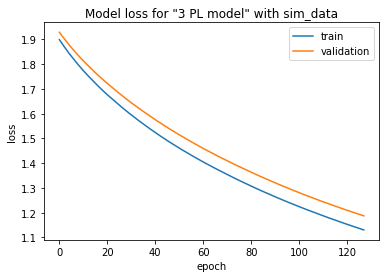

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for "3 PL model" with sim_data')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(['train', 'validation'], loc= 'upper right')
plt.show()

### Obtaining underlying trained 3pl parameters from keras model

In [18]:
for idx in [2,3,5,6]:
    print('layer no: {} is named: {}'.format(idx, model3_sim.layers[idx].name))

layer no: 2 is named: latent_trait
layer no: 3 is named: difficulty_level
layer no: 5 is named: disc_param
layer no: 6 is named: guessing_param


In [19]:
latent_trait_parameters = model3_sim.layers[2].get_weights()[0]#latent trait for 500 users
difficulty_level_parameters= model3_sim.layers[3].get_weights()[0]#difficulty params for 3 Quests/item.
discrimination_parameters= model3_sim.layers[5].get_weights()[0]#dicrimination params for 3 Quests/item.
pseudo_guess_parameters = model3_sim.layers[6].get_weights()[0]#pseudo_guess_params for 3 Quests/item.

In [20]:
difficulty_level_parameters

array([[ 0.24221405],
       [ 0.73399734],
       [-0.49118078]], dtype=float32)

In [21]:
discrimination_parameters

array([[ 1.066449  ],
       [ 1.7406464 ],
       [-0.13321339]], dtype=float32)

In [22]:
pseudo_guess_parameters = np.exp(pseudo_guess_parameters)/(1+ np.exp(pseudo_guess_parameters))
pseudo_guess_parameters#New after sigmoid(weights)

array([[0.4714199 ],
       [0.32722604],
       [0.25353825]], dtype=float32)

### Loading R's 3PL model paramters from simulated dataset for comparison


In [23]:
coeff = pd.read_csv('simulated_data_r_coeffs.csv')
coeff.head(3)

,Unnamed: 0,Gussng,Dffclt,Dscrmn
0,V1,0.048993,-0.539199,23.963986
1,V2,0.000008,0.044664,21.340652
2,V3,0.000003,0.695396,18.530009


In [24]:
r_params_cols =list(coeff.columns)
r_params_cols#columns from R's dataframe

['Unnamed: 0', 'Gussng', 'Dffclt', 'Dscrmn']

### Table representation of param values from keras Vs. R

In [25]:
rel_items= list(range(1, df_sim['questions'].nunique()+1))

In [26]:
df_table= pd.DataFrame({'Questions': rel_items, 'Difficulty-keras': difficulty_level_parameters.reshape(-1),
 'Difficulty-R':coeff[r_params_cols[2]].values, 'Discrimination-keras':discrimination_parameters.reshape(-1),
 'Discrimination-R':coeff[r_params_cols[-1]].values, 'Guess-keras':pseudo_guess_parameters.reshape(-1),
 'Guess-R':coeff[r_params_cols[2]].values})
df_table.head(5)

,Questions,Difficulty-keras,Difficulty-R,Discrimination-keras,Discrimination-R,Guess-keras,Guess-R
0,1,0.242214,-0.539199,1.066449,23.963986,0.471420,-0.539199
1,2,0.733997,0.044664,1.740646,21.340652,0.327226,0.044664
2,3,-0.491181,0.695396,-0.133213,18.530009,0.253538,0.695396


In [27]:
normalized_diff_r=coeff[r_params_cols[2]]#/coeff[r_params_cols[2]].sum()
normalized_diff_r#new difficulty vals from R

0   -0.539199
1    0.044664
2    0.695396
Name: Dffclt, dtype: float64

## Scatterplots

### 1. Difficulty vals from keras_3pl vs. R_3pl

* R_tpm values are plotted across X
* Keras values are plotted across Y

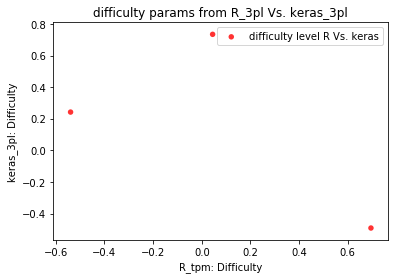

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (difficulty_level_parameters.reshape(-1), normalized_diff_r.values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="difficulty level R Vs. keras")
plt.title('difficulty params from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: Difficulty')
plt.xlabel('R_tpm: Difficulty')
plt.legend(loc=1)

plt.show()

### 2. Discrimination vals from keras_3pl vs. R_3pl

* R_tpm values are plotted across X
* Keras values are plotted across Y

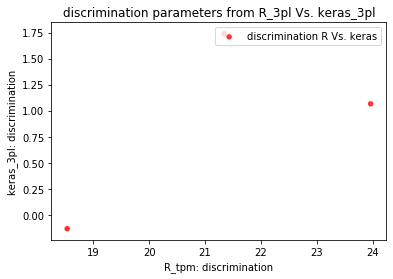

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (discrimination_parameters, coeff[r_params_cols[-1]].values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="discrimination R Vs. keras")
plt.title('discrimination parameters from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: discrimination')
plt.xlabel('R_tpm: discrimination')

plt.legend(loc=1)
plt.show()

### 3. Guessing param values from keras_3pl vs. R_3pl

* R_tpm values are plotted across X
* Keras values are plotted across Y


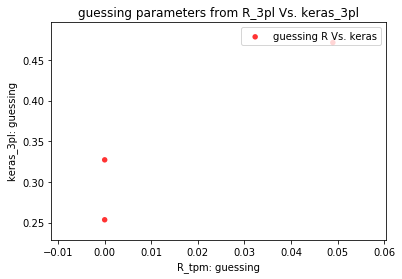

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
y,x = (pseudo_guess_parameters, coeff[r_params_cols[1]].values)

ax.scatter(x, y, alpha=0.8, c="red", edgecolors='none', s=30, label="guessing R Vs. keras")
plt.title('guessing parameters from R_3pl Vs. keras_3pl')
plt.ylabel('keras_3pl: guessing')
plt.xlabel('R_tpm: guessing')

plt.legend(loc=1)
plt.show()

## Item characteristic curves for all 3 items from simulated dataset with R tpm

In [31]:
def logit_func(lat_values):#c:guess, a:descrimination, b:difficulty
    prob = list()
    prob.append(c+ (1-c)*(np.exp(a*(lat_values-b))/(1+np.exp(a*(lat_values-b)))))#Vectorised implementation
    #for val in lat_values:
    #    prob.append(c+ (1-c)*(np.exp(a*(val-b))/(1+np.exp(a*(val-b)))))
    return prob

In [32]:
x = np.linspace(-4,4, num=num_sim_users)#value count for x axis

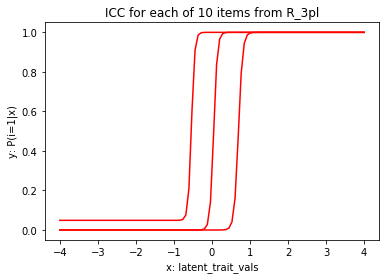

In [33]:
for i in range(coeff.shape[0]):
    c= coeff[r_params_cols[1]].iloc[i]#values of item 6 from R's dataframe
    a= coeff[r_params_cols[-1]].iloc[i]
    b= coeff[r_params_cols[2]].iloc[i]
    vals_r= logit_func(x)
    plt.plot(x,vals_r[0], 'r')

plt.title('ICC for each of 10 items from R_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()

## Item characteristic curves for all items from simulated dataset with keras 3PL

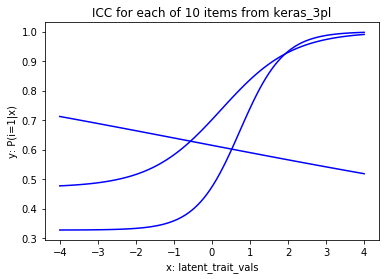

In [34]:
for i in range(len(rel_items)):#10 items
    c= pseudo_guess_parameters[i]#values for item 6 from keras 3pl params
    a= discrimination_parameters[i]
    b= difficulty_level_parameters[i]
    vals_keras= logit_func(x)
    plt.plot(x,vals_keras[0], 'b')

plt.title('ICC for each of 10 items from keras_3pl')
plt.xlabel('x: latent_trait_vals')
plt.ylabel('y: P(i=1|x)')
plt.show()#for mean=0 stdDev=1

_____________________